# Torch with Pretrained Weigths and Encoder

### In this project, my purpose is to applying segmentation to water bodies. Feel free to check my repo on github...

### https://github.com/uraninjo/SatelliteWaterBodies



In [ ]:
!pip install --upgrade opencv-contrib-python
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations

In [70]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import os
import glob
import cv2
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from albumentations import HorizontalFlip, VerticalFlip, Rotate
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.image as mpimg
import albumentations as A

height,width = (256, 256)


torch.cuda.is_available()

True

**Before our model preperation, we need to edit the data and we need to make the photo the shape we want for our model.**

**For this, we create a class for ourselves and write the functions we want in it.**

In [104]:
class LoadData(Dataset):
    def __init__(self, images_path, masks_path):
        super().__init__()

        self.images_path = images_path
        self.masks_path = masks_path
        self.len = len(images_path)
        self.transform = A.Compose([
            A.Resize(height,width),
            A.HorizontalFlip(),
            A.RandomBrightnessContrast(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        ])
        

    def __getitem__(self, idx):
        img = Image.open(self.images_path[idx])
        mask = Image.open(self.masks_path[idx]).convert('L')
        
        img,mask=np.array(img),np.array(mask)
        transformed = self.transform(image=img, mask=mask)
        img = transformed['image']
        mask = transformed['mask']

        img = np.transpose(img, (2, 0, 1))
        img = img/255.0
        img = torch.tensor(img)

        mask = np.expand_dims(mask, axis=0)
        mask = mask/255.0
        mask = torch.tensor(mask)

        return img, mask
    
    def __len__(self):
        return self.len

**We load the data with glob as X-Y...**

In [105]:
X = sorted(glob.glob('../input/satellite-images-of-water-bodies/Water Bodies Dataset/Images/*'))
y = sorted(glob.glob('../input/satellite-images-of-water-bodies/Water Bodies Dataset/Masks/*'))

**We need to check the existence of the data we are uploading. If a wrong path is entered here, our result below will be 0.**

In [106]:
len(y)

2841

**We seperate our data for train and validation and shape it with our above class.**

In [107]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

In [108]:
train_dataset = LoadData(X_train, y_train)
valid_dataset = LoadData(X_val, y_val)

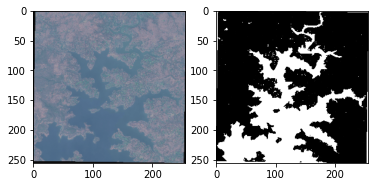

In [109]:
img, mask = train_dataset[18]

f, axarr = plt.subplots(1,2) 
axarr[1].imshow(np.squeeze(mask.numpy()), cmap='gray')
axarr[0].imshow(np.transpose(img.numpy(), (1,2,0)))


**This settings are customizable you could change it as you want. Encoder selection is important, your results will be according to it...**

In [110]:
DEVICE='cuda'

EPOCHS=45
BATCH_SIZE=32
LR=0.001

ratio=0.5 #Various ratios could perform better for visualization
sample_num=18

ENCODER='resnet50'
WEIGHTS='imagenet'

**We load the data with DataLoader...**

In [111]:
train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=2,
)

valid_loader = DataLoader(
        dataset=valid_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=2,
)


**Here we determine the encoder and weights from the above variables in Unet.**

**The value of our loss function is the sum of the DiceLoss and BCEWithLogitsLoss.**

In [112]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [113]:
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel,self).__init__()

        self.arc=smp.Unet(
            encoder_name=ENCODER,
            encoder_weights=WEIGHTS,
            in_channels=3,
            classes=1,
            activation=None
        )
    def forward(self,images,masks=None):
        logits=self.arc(images)

        if masks!=None:
            loss1=DiceLoss(mode='binary')(logits,masks)
            loss2=nn.BCEWithLogitsLoss()(logits,masks)
            return logits,loss1,loss2
        return logits

In [114]:
model=SegmentationModel()
model.to(DEVICE)

SegmentationModel(
  (arc): Unet(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReL

**We write the function to be used for training and eval so that things are simplified in the training cycle.**

In [115]:
def train_fn(data_loader,model,optimizer):
    model.train()
    total_diceloss=0.0
    total_bceloss=0.0
    for images ,masks in tqdm(data_loader):
        images=images.to(DEVICE, dtype=torch.float32)
        masks=masks.to(DEVICE, dtype=torch.float32)

        optimizer.zero_grad()

        logits,diceloss,bceloss=model(images,masks)
        diceloss.backward(retain_graph=True)
        bceloss.backward()
        optimizer.step()
        total_diceloss+=diceloss.item()
        total_bceloss+=bceloss.item()
        

    return total_diceloss/len(data_loader),total_bceloss/len(data_loader)

In [116]:
def eval_fn(data_loader,model):
    model.eval()
    total_diceloss=0.0
    total_bceloss=0.0
    with torch.no_grad():
        for images ,masks in tqdm(data_loader):
            images=images.to(DEVICE, dtype=torch.float32)
            masks=masks.to(DEVICE, dtype=torch.float32)

            logits,diceloss,bceloss=model(images,masks)
            total_diceloss+=diceloss.item()
            total_bceloss+=bceloss.item()
            
        #Visualization
        for i in range(1):
            image,mask=next(iter(valid_loader))
            image=image[sample_num]
            mask=mask[sample_num]
            logits_mask=model(image.to('cuda', dtype=torch.float32).unsqueeze(0))
            pred_mask=torch.sigmoid(logits_mask)
            pred_mask=(pred_mask > ratio)*1.0
            f, axarr = plt.subplots(1,3) 
            axarr[1].imshow(np.squeeze(mask.numpy()), cmap='gray')
            axarr[0].imshow(np.transpose(image.numpy(), (1,2,0)))
            axarr[2].imshow(np.transpose(pred_mask.detach().cpu().squeeze(0), (1,2,0)))
            plt.show()
            
    return total_diceloss/len(data_loader),total_bceloss/len(data_loader)


In [117]:
optimizer=torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9)
#torch.optim.Adam(model.parameters(),lr=LR)

**We use the adam optimizer and set up our training loop.**

**Here we want to save the best model and see our loss at every step...**

100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


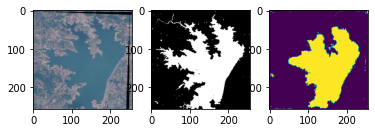

Epochs:1
Train_loss --> Dice: 0.49592944234609604 BCE: 0.5675729185342788 
Valid_loss --> Dice: 0.38298312160703873 BCE: 0.4096416102515327
Model Saved


100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


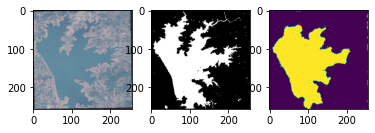

Epochs:2
Train_loss --> Dice: 0.33523775935173034 BCE: 0.3865573361515999 
Valid_loss --> Dice: 0.30012817515267265 BCE: 0.3319745593600803
Model Saved


100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


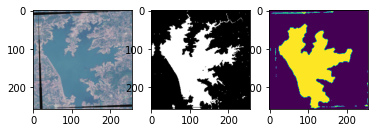

Epochs:3
Train_loss --> Dice: 0.2806070864200592 BCE: 0.3450304543599486 
Valid_loss --> Dice: 0.2664777835210164 BCE: 0.3228459341658486
Model Saved


100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


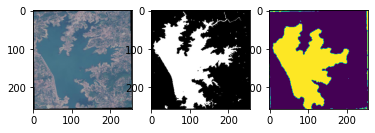

Epochs:4
Train_loss --> Dice: 0.2584164202213287 BCE: 0.32674694489687683 
Valid_loss --> Dice: 0.26163676712248063 BCE: 0.30582889914512634
Model Saved


100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


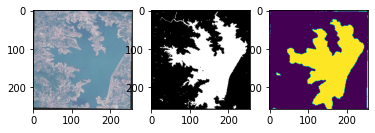

Epochs:5
Train_loss --> Dice: 0.24071185290813446 BCE: 0.30769603457301853 
Valid_loss --> Dice: 0.24496195051405165 BCE: 0.2906068116426468
Model Saved


100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


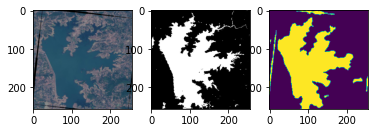

Epochs:6
Train_loss --> Dice: 0.22745192870497705 BCE: 0.29402980767190456 
Valid_loss --> Dice: 0.2540942496723599 BCE: 0.299039622147878


100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


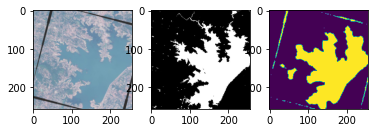

Epochs:7
Train_loss --> Dice: 0.22031046375632285 BCE: 0.28716450594365595 
Valid_loss --> Dice: 0.23290024863349068 BCE: 0.28653113378418815
Model Saved


100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


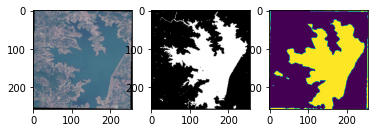

Epochs:8
Train_loss --> Dice: 0.21580577418208122 BCE: 0.2831992357969284 
Valid_loss --> Dice: 0.2228112750583225 BCE: 0.27354242073165047
Model Saved


100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


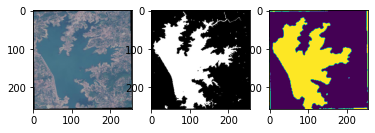

Epochs:9
Train_loss --> Dice: 0.20541631951928138 BCE: 0.2712395215407014 
Valid_loss --> Dice: 0.21523768372005886 BCE: 0.2720116625229518
Model Saved


100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


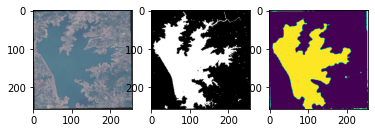

Epochs:10
Train_loss --> Dice: 0.20209575444459915 BCE: 0.26684103440493345 
Valid_loss --> Dice: 0.2252216339111328 BCE: 0.2827919688489702


100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


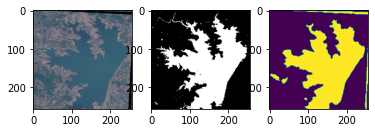

Epochs:11
Train_loss --> Dice: 0.1991533860564232 BCE: 0.2617494219914079 
Valid_loss --> Dice: 0.20976665947172377 BCE: 0.26345031956831616
Model Saved


100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


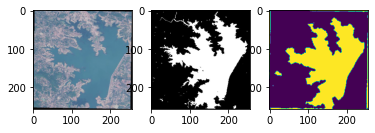

Epochs:12
Train_loss --> Dice: 0.18990365117788316 BCE: 0.25001635681837797 
Valid_loss --> Dice: 0.2013738685184055 BCE: 0.25495358804861706
Model Saved


100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


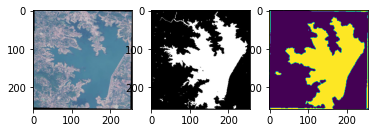

Epochs:13
Train_loss --> Dice: 0.1832832559943199 BCE: 0.24665973614901304 
Valid_loss --> Dice: 0.20570877525541517 BCE: 0.2681114359034432


100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


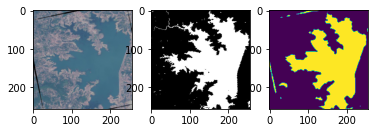

Epochs:14
Train_loss --> Dice: 0.18224366530776023 BCE: 0.2428840607404709 
Valid_loss --> Dice: 0.20398618777592978 BCE: 0.25724052389462787


100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


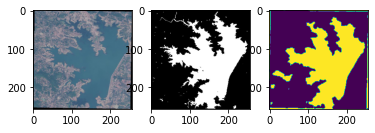

Epochs:15
Train_loss --> Dice: 0.18078683614730834 BCE: 0.2387747211381793 
Valid_loss --> Dice: 0.19678843021392822 BCE: 0.258546104033788
Model Saved


100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


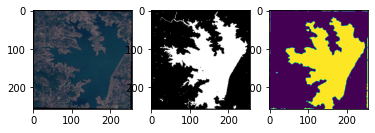

Epochs:16
Train_loss --> Dice: 0.17390145733952522 BCE: 0.23553249817341565 
Valid_loss --> Dice: 0.1914484699567159 BCE: 0.24928560356299082
Model Saved


100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


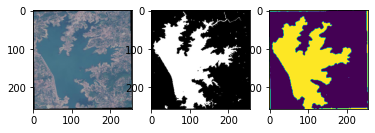

Epochs:17
Train_loss --> Dice: 0.1734233781695366 BCE: 0.23080299645662308 
Valid_loss --> Dice: 0.191554327805837 BCE: 0.25477975110212964


100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


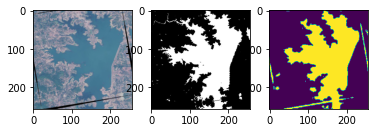

Epochs:18
Train_loss --> Dice: 0.16941184923052788 BCE: 0.2269542334601283 
Valid_loss --> Dice: 0.1922200255923801 BCE: 0.2567479544215732


100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


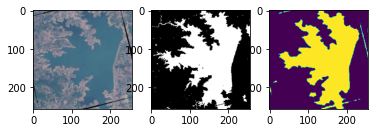

Epochs:19
Train_loss --> Dice: 0.16655717566609382 BCE: 0.22171533070504665 
Valid_loss --> Dice: 0.18597122033437094 BCE: 0.2480220446983973
Model Saved


100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


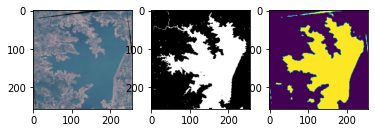

Epochs:20
Train_loss --> Dice: 0.1649024248123169 BCE: 0.22119463719427584 
Valid_loss --> Dice: 0.19089851114484999 BCE: 0.24513171116511026
Model Saved


100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


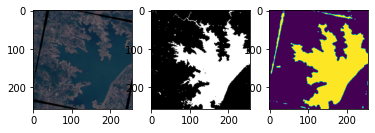

Epochs:21
Train_loss --> Dice: 0.16084954217076303 BCE: 0.2149381224066019 
Valid_loss --> Dice: 0.18695391549004448 BCE: 0.2507927003833983
Model Saved


100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


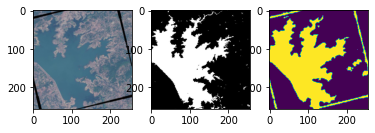

Epochs:22
Train_loss --> Dice: 0.15493591278791427 BCE: 0.21037663649767638 
Valid_loss --> Dice: 0.18109926250245836 BCE: 0.2457592553562588
Model Saved


100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


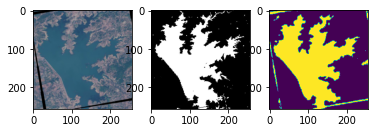

Epochs:23
Train_loss --> Dice: 0.1540309302508831 BCE: 0.2071012120693922 
Valid_loss --> Dice: 0.18242551220787895 BCE: 0.2424828890297148
Model Saved


100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


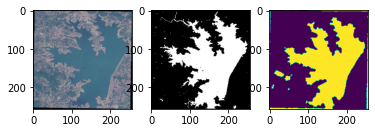

Epochs:24
Train_loss --> Dice: 0.15611691474914552 BCE: 0.20962854977697135 
Valid_loss --> Dice: 0.17729911539289686 BCE: 0.24516838954554665
Model Saved


100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


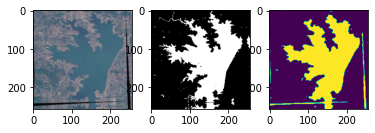

Epochs:25
Train_loss --> Dice: 0.1506102092564106 BCE: 0.20406036488711835 
Valid_loss --> Dice: 0.18582695722579956 BCE: 0.24943382375770146


100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


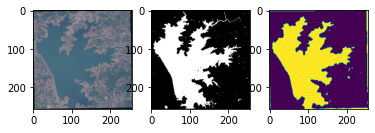

Epochs:26
Train_loss --> Dice: 0.15005323067307472 BCE: 0.2033313328400254 
Valid_loss --> Dice: 0.18150844838884142 BCE: 0.24282311234209272
Model Saved


100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


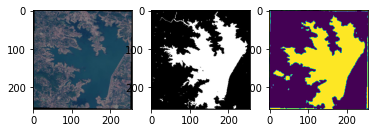

Epochs:27
Train_loss --> Dice: 0.14680270552635194 BCE: 0.198947131074965 
Valid_loss --> Dice: 0.1805291838116116 BCE: 0.2571467293633355
Model Saved


100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


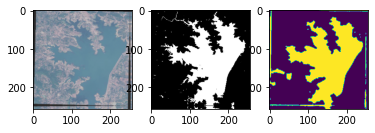

Epochs:28
Train_loss --> Dice: 0.145573028922081 BCE: 0.19559211656451225 
Valid_loss --> Dice: 0.17572690380944145 BCE: 0.24393656684292686
Model Saved


100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


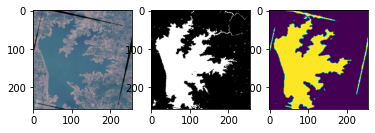

Epochs:29
Train_loss --> Dice: 0.14271580204367637 BCE: 0.19263029135763646 
Valid_loss --> Dice: 0.17315098312166002 BCE: 0.2393388549486796
Model Saved


100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


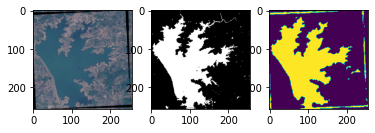

Epochs:30
Train_loss --> Dice: 0.14047750309109688 BCE: 0.1927547321654856 
Valid_loss --> Dice: 0.17548862430784437 BCE: 0.2497359961271286


100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


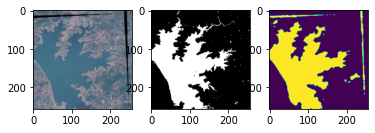

Epochs:31
Train_loss --> Dice: 0.14075247719883918 BCE: 0.18835341483354567 
Valid_loss --> Dice: 0.17675413688023886 BCE: 0.24392205642329323


100%|██████████| 9/9 [00:07<00:00,  1.27it/s]


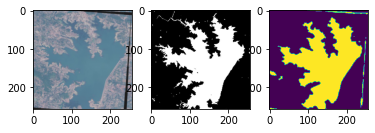

Epochs:32
Train_loss --> Dice: 0.1395989589393139 BCE: 0.19012284483760594 
Valid_loss --> Dice: 0.1724332703484429 BCE: 0.24739322397443983
Model Saved


100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


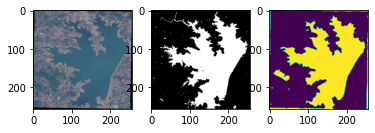

Epochs:33
Train_loss --> Dice: 0.1354822926223278 BCE: 0.183977453969419 
Valid_loss --> Dice: 0.17505605353249443 BCE: 0.24881029625733694


100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


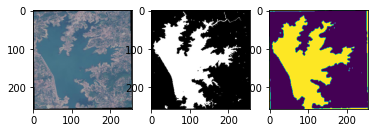

Epochs:34
Train_loss --> Dice: 0.13501725494861602 BCE: 0.18388264905661345 
Valid_loss --> Dice: 0.17389894856346977 BCE: 0.23539945648776162
Model Saved


100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


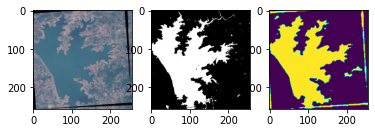

Epochs:35
Train_loss --> Dice: 0.135556211322546 BCE: 0.18432572893798352 
Valid_loss --> Dice: 0.16986033651563856 BCE: 0.23875982562700906
Model Saved


100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


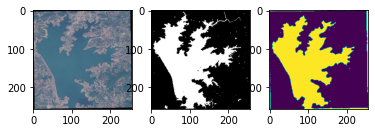

Epochs:36
Train_loss --> Dice: 0.1331466980278492 BCE: 0.18098961804062128 
Valid_loss --> Dice: 0.17092772987153795 BCE: 0.2490854346089893


100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


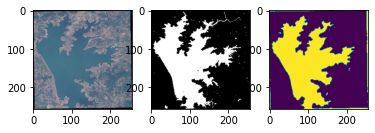

Epochs:37
Train_loss --> Dice: 0.13168274685740472 BCE: 0.18108350560069084 
Valid_loss --> Dice: 0.1710625622007582 BCE: 0.24617120623588562


100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


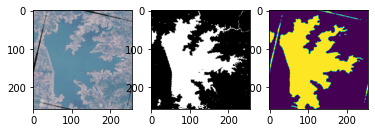

Epochs:38
Train_loss --> Dice: 0.12994074672460557 BCE: 0.17620069477707148 
Valid_loss --> Dice: 0.1647823386722141 BCE: 0.24657029079066384
Model Saved


100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


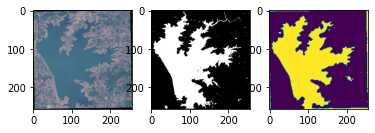

Epochs:39
Train_loss --> Dice: 0.1293211594223976 BCE: 0.1753534058108926 
Valid_loss --> Dice: 0.16512109835942587 BCE: 0.23257938358518812
Model Saved


100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


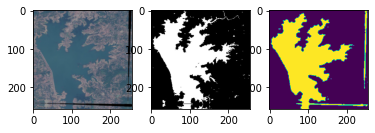

Epochs:40
Train_loss --> Dice: 0.1294405959546566 BCE: 0.17525511076673866 
Valid_loss --> Dice: 0.16840316189659965 BCE: 0.24980909956826103


100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


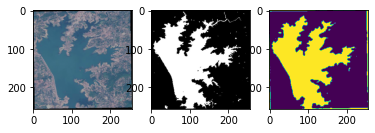

Epochs:41
Train_loss --> Dice: 0.1262630969285965 BCE: 0.17234121542423964 
Valid_loss --> Dice: 0.1665553649266561 BCE: 0.2575200315978792


100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


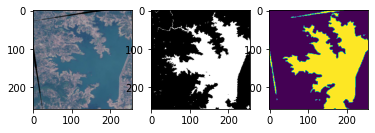

Epochs:42
Train_loss --> Dice: 0.12399773746728897 BCE: 0.1700971983373165 
Valid_loss --> Dice: 0.16516874233881632 BCE: 0.24697376125388676


100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


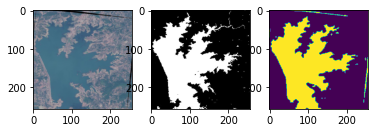

Epochs:43
Train_loss --> Dice: 0.1219284787774086 BCE: 0.16809221571311356 
Valid_loss --> Dice: 0.16284823417663574 BCE: 0.2446573343541887
Model Saved


100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


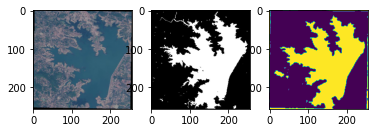

Epochs:44
Train_loss --> Dice: 0.12197017818689346 BCE: 0.1663166642189026 
Valid_loss --> Dice: 0.1585007045004103 BCE: 0.2330772429704666
Model Saved


100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


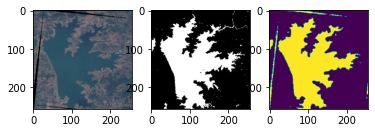

Epochs:45
Train_loss --> Dice: 0.12092272564768791 BCE: 0.16676811035722494 
Valid_loss --> Dice: 0.1640765733189053 BCE: 0.24578294654687247


In [118]:
best_val_dice_loss=np.Inf
best_val_bce_loss=np.Inf

for i in range(EPOCHS):
    train_loss = train_fn(train_loader,model,optimizer)
    valid_loss = eval_fn(valid_loader,model)
    
    train_dice,train_bce=train_loss
    valid_dice,valid_bce=valid_loss
    print(f'Epochs:{i+1}\nTrain_loss --> Dice: {train_dice} BCE: {train_bce} \nValid_loss --> Dice: {valid_dice} BCE: {valid_bce}')
    if valid_dice < best_val_dice_loss or valid_bce < best_val_bce_loss:
        torch.save(model.state_dict(),'best_model.pt')
        print('Model Saved')
        best_val_dice_loss=valid_dice
        best_val_bce_loss=valid_bce

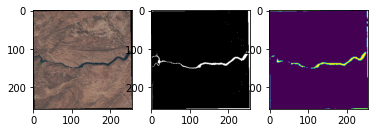

In [123]:
num=11
ratio=0.5

model.load_state_dict(torch.load('./best_model.pt'))

image,mask=next(iter(valid_loader))
image=image[num]
mask=mask[num]
logits_mask=model(image.to('cuda', dtype=torch.float32).unsqueeze(0))
pred_mask=torch.sigmoid(logits_mask)
pred_mask=(pred_mask > ratio)*1.0

f, axarr = plt.subplots(1,3) 
axarr[1].imshow(np.squeeze(mask.numpy()), cmap='gray')
axarr[0].imshow(np.transpose(image.numpy(), (1,2,0)))
axarr[2].imshow(np.transpose(pred_mask.detach().cpu().squeeze(0), (1,2,0)))